In [1]:
import wget

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2025-02-09 12:11:10--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.203.155, 142.250.186.219, 216.58.215.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.203.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.08s   

2025-02-09 12:11:10 (6.88 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [3]:
import zipfile

In [4]:
zip_ref = zipfile.ZipFile("nlp_getting_started.zip")

In [5]:
zip_ref.extractall()

In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [6]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)

In [7]:
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
train_df_shuffled["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(), train_df_shuffled["target"].to_numpy(), test_size=0.1, random_state=42)

In [12]:
import tensorflow as tf

In [13]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [15]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=10000, output_mode="int", output_sequence_length=15)

In [16]:
text_vectorizer.adapt(train_sentences)

In [46]:
sample_sentence = "There's a flood in my street!"

In [47]:
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [48]:
text_vectorizer.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('the'),
 np.str_('a'),
 np.str_('in'),
 np.str_('to'),
 np.str_('of'),
 np.str_('and'),
 np.str_('i'),
 np.str_('is')]

Спочатку сортує слова за частотою спадання, а потім присвоює їм індекси.

In [17]:
embedding = tf.keras.layers.Embedding(input_dim=10000, output_dim=128, mask_zero=True)

In [19]:
embedding(text_vectorizer([sample_sentence])).shape

TensorShape([1, 15, 128])

In [20]:
embedding(text_vectorizer([sample_sentence])).numpy()

array([[[ 0.02910933,  0.04815341, -0.00858444, ...,  0.0420501 ,
          0.0264717 , -0.04638163],
        [-0.04832396,  0.03123695, -0.00842183, ..., -0.04936602,
          0.03698296, -0.01486546],
        [ 0.04134119,  0.03955947,  0.04055898, ..., -0.01066973,
         -0.04862262, -0.01425359],
        ...,
        [ 0.04414951,  0.02334436,  0.02858191, ..., -0.00252366,
         -0.03232914, -0.03561599],
        [ 0.04414951,  0.02334436,  0.02858191, ..., -0.00252366,
         -0.03232914, -0.03561599],
        [ 0.04414951,  0.02334436,  0.02858191, ..., -0.00252366,
         -0.03232914, -0.03561599]]], dtype=float32)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
from sklearn.naive_bayes import MultinomialNB

In [15]:
from sklearn.pipeline import Pipeline

In [16]:
model1 = Pipeline([("tfidf", TfidfVectorizer()), ("clf", MultinomialNB())])

In [17]:
model1.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [18]:
model1.score(val_sentences, val_labels)

0.7926509186351706

In [18]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model2 = tf.keras.Model(inputs, outputs)

model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model2.fit(train_sentences, train_labels, epochs=5, validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6753 - loss: 0.6481 - val_accuracy: 0.7664 - val_loss: 0.5188
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8242 - loss: 0.4378 - val_accuracy: 0.7835 - val_loss: 0.4686
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8696 - loss: 0.3315 - val_accuracy: 0.7940 - val_loss: 0.4597
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8966 - loss: 0.2656 - val_accuracy: 0.7927 - val_loss: 0.4771
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9143 - loss: 0.2267 - val_accuracy: 0.7913 - val_loss: 0.4903


In [20]:
model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 15)        │          0 │ input_layer[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 15, 128)   │  1,280,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 15)        │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ embedding[0][0],  │
│ (GlobalAveragePool… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

In [21]:
model2.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7693 - loss: 0.5233


[0.48774948716163635, 0.7847769260406494]

In [22]:
model2.predict(val_sentences).shape

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


(762, 1)

In [21]:
model2.predict(val_sentences[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


array([[0.31220016]], dtype=float32)

<Axes: >

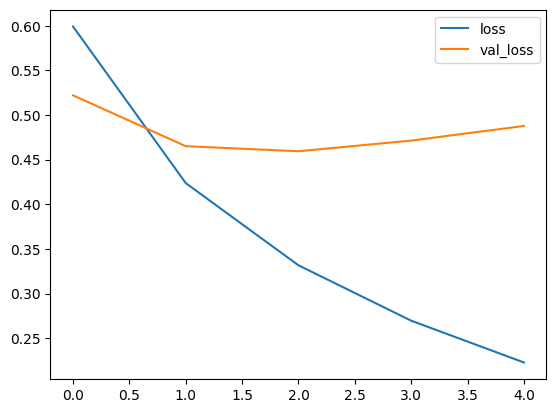

In [24]:
pd.DataFrame({"loss": history.history["loss"], "val_loss": history.history["val_loss"]}).plot()

In [26]:
model2.get_layer("embedding").get_weights()[0].shape

(10000, 128)

In [34]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
print(x.shape)
x = tf.keras.layers.LSTM(64)(x)
print(x.shape)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model3 = tf.keras.Model(inputs, outputs)

model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model3.fit(train_sentences, train_labels, epochs=5, validation_data=(val_sentences, val_labels))

(None, 15, 128)
(None, 15, 64)
(None, 64)
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9587 - loss: 0.2197 - val_accuracy: 0.7717 - val_loss: 0.9467
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9794 - loss: 0.0539 - val_accuracy: 0.7756 - val_loss: 1.1414
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9768 - loss: 0.0662 - val_accuracy: 0.7677 - val_loss: 1.4979
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9797 - loss: 0.0429 - val_accuracy: 0.7546 - val_loss: 1.4853
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9809 - loss: 0.0419 - val_accuracy: 0.7625 - val_loss: 1.4996


In [45]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model5 = tf.keras.Model(inputs, outputs)

model5.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model5.fit(train_sentences, train_labels, epochs=5, validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.9234 - loss: 0.1561 - val_accuracy: 0.7559 - val_loss: 1.1060
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.9853 - loss: 0.0349 - val_accuracy: 0.7598 - val_loss: 1.5348
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9843 - loss: 0.0335 - val_accuracy: 0.7507 - val_loss: 1.5455
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9809 - loss: 0.0367 - val_accuracy: 0.7493 - val_loss: 1.5560
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9822 - loss: 0.0311 - val_accuracy: 0.7585 - val_loss: 1.8238


In [46]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="valid", activation="relu")(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model6 = tf.keras.Model(inputs, outputs)

model6.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model6.fit(train_sentences, train_labels, epochs=5, validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9387 - loss: 0.1782 - val_accuracy: 0.7493 - val_loss: 0.9892
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9764 - loss: 0.0641 - val_accuracy: 0.7467 - val_loss: 1.1195
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9808 - loss: 0.0476 - val_accuracy: 0.7493 - val_loss: 1.1592
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9823 - loss: 0.0445 - val_accuracy: 0.7507 - val_loss: 1.2413
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9827 - loss: 0.0378 - val_accuracy: 0.7507 - val_loss: 1.2440


In [11]:
import tensorflow_hub as hub

In [14]:
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False
)

In [17]:
train_embeddings = sentence_encoder_layer(train_sentences)
val_embeddings = sentence_encoder_layer(val_sentences)

model7 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(512,)),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model7.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model7.fit(train_embeddings, train_labels, epochs=5, validation_data=(val_embeddings, val_labels))

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6880 - loss: 0.6672 - val_accuracy: 0.7690 - val_loss: 0.6119
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7881 - loss: 0.5930 - val_accuracy: 0.7769 - val_loss: 0.5622
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7933 - loss: 0.5454 - val_accuracy: 0.7822 - val_loss: 0.5306
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7941 - loss: 0.5166 - val_accuracy: 0.7861 - val_loss: 0.5103
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8019 - loss: 0.4938 - val_accuracy: 0.7874 - val_loss: 0.4961


In [19]:
train_embeddings.shape, val_embeddings.shape

(TensorShape([6851, 512]), TensorShape([762, 512]))

In [21]:
train_sentences10, _, train_labels10, _ = train_test_split(train_sentences, train_labels, test_size=0.9, random_state=42)

In [24]:
train_embeddings10 = sentence_encoder_layer(train_sentences10)

model8 = tf.keras.models.clone_model(model7)

model8.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model8.fit(train_embeddings10, train_labels10, epochs=5, validation_data=(val_embeddings, val_labels))

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5582 - loss: 0.6882 - val_accuracy: 0.6115 - val_loss: 0.6824
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6745 - loss: 0.6751 - val_accuracy: 0.6588 - val_loss: 0.6740
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7308 - loss: 0.6643 - val_accuracy: 0.6772 - val_loss: 0.6660
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7336 - loss: 0.6554 - val_accuracy: 0.6942 - val_loss: 0.6584
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7270 - loss: 0.6470 - val_accuracy: 0.7100 - val_loss: 0.6507
